# Basic training loops
This notebook showcase a basic training loop developed using TensorFlow and Keras features and API. See the guide here: https://www.tensorflow.org/guide/basic_training_loops.
The notebook uses Tensors, TensorFlow Variables, gradient tape and modules as well as using the Keras API to construct a model.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

2023-02-05 15:22:55.890678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 15:23:09.565850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-05 15:23:09.565925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-05 15:23:09.565931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Solving machine learning problems
Solving a machine learning problem ususally consists of the following steps:
- Obtain training data
- Define the model
- Define loss function
- Run through the training data
  - Calculate loss from the ideal value
  - Calculate gradients for that loss and use an optimizer to adjust the variables to fit the data
- Evaluate results

In this notebook, we'll develelop a simple linear model $ f(x) = x * W + b $ , which has two variables: $ W $ (weights) and $ b $ (bias).

## Data
Supervised learning uses inputs (usually denoted as x) and outputs (denoted y, often called labels). The goal is to learn from paired inputs and outputs so that you can predict the value of an output from an input.
Each intput of data in  TensorFlow is almost always represented by a tensor, and if often a vector. In superviser training, the output is also a tensor.

Here is some data synthesized by adding Gaussian (Normal) noise to points along a line.

In [29]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# Vector of random x values
x = tf.linspace(-2, 2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
    return x * TRUE_W + TRUE_B

# Generate some noise (cloud of points)
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

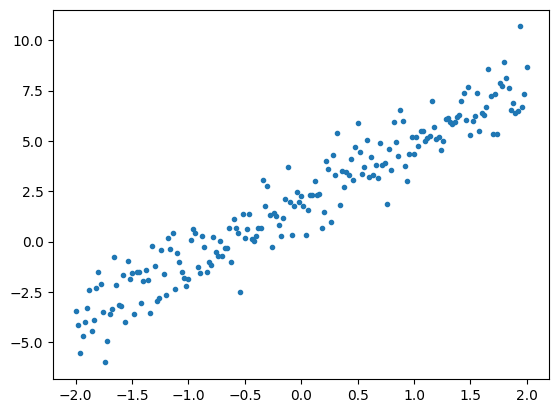

In [30]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

## Define the model
We can use **tf.Variable** to represent all weights in a model. A **tf.Variable** stores a value and provides this in tensor form as needed.
Use **tf.Module** to encapsulate the variables and the computation. It is psosibly to use any Python object, but this way it can be easily saved.

Let's define both *w* and *b* as variables.

In [34]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.module's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


## Define a loss function
A loss function measures how well the output of a model for a given input matches the target output. The goal is to **minimise** this difference during training. Define the standard L2 loss, also known as the "mean squared" error:

In [40]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

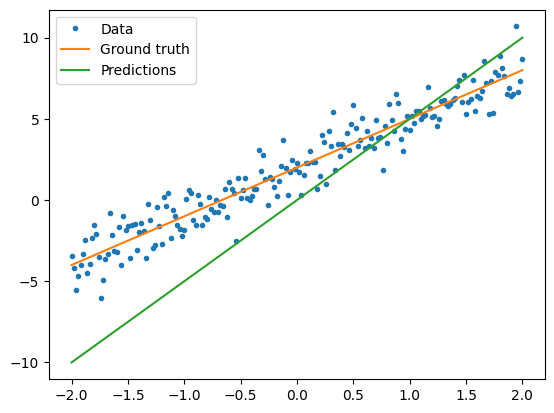

Current loss: 10.631033


In [41]:
# Visualise the loss value by plotting the model's prediction in red and the training data in blue
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label='Ground truth')
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

## Define a training loop
The training loop consists of repeatedly doing three tasks in order:
1. Sending a batch of inputs through the model to generate outputs
2. Calculating the loss by comparing the outputs to the output (or label)
3. Using gradient tape to find the gradients
4. Optimising the variables with those gradients

For this example, we can train the model using gradient descent.

There are many variants of the gradient descent schema that are captured in **tf.keras.optimizers**. But in the spirit of building from first principles, we will implement the basic math ourselves with the help of tf.GradientTape for automatic differentiation and tf.assign_sub for decrementing a value (which combines tf.assign and tf.sub).

In [42]:
# Given a callable model, inputs, outputs and a learning rate...
def train(model, x, y, learning_rate):
    with tf.GradientTape() as tape:
        # Trainable variables are automatically tracked by GradientTape
        current_loss = loss(y, model(x))

    # Use GradientTape to calculate the gradients with respect to W and b
    dw, db = tape.gradient(current_loss, [model.w, model.b])

    # Subtract the gradient scaled by the learning rate
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

In [43]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

def training_loop(model, x, y):
    for epoch in epochs:
        # Update the model with the single giant batch
        train(model, x, y, learning_rate=0.1)

        # Track this before I update
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())

        current_loss = loss(y, model(x))

        print(f"Epoch {epoch:2d}:")
        print("    ", report(model, current_loss))

In [44]:
# Do the training
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.63103
Epoch  0:
     W = 4.45, b = 0.40, loss=6.57630
Epoch  1:
     W = 4.05, b = 0.72, loss=4.25796
Epoch  2:
     W = 3.76, b = 0.98, loss=2.92193
Epoch  3:
     W = 3.54, b = 1.18, loss=2.14573
Epoch  4:
     W = 3.39, b = 1.35, loss=1.69107
Epoch  5:
     W = 3.27, b = 1.48, loss=1.42256
Epoch  6:
     W = 3.19, b = 1.58, loss=1.26271
Epoch  7:
     W = 3.13, b = 1.67, loss=1.16681
Epoch  8:
     W = 3.08, b = 1.74, loss=1.10886
Epoch  9:
     W = 3.05, b = 1.79, loss=1.07360


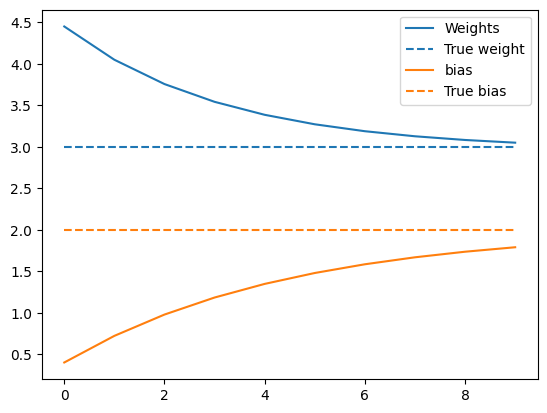

In [45]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

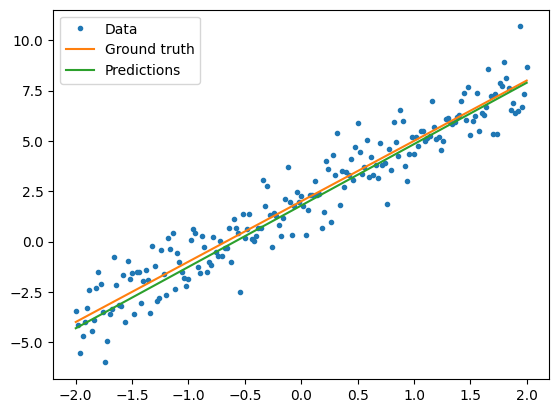

Current loss: 1.073598


In [46]:
# Visualise how the trained model performs
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## Same solution, but with Keras
Let's see the comparaison of the algorithm defined above using Keras which strongly simplify the process
Defining the model looks exactly the same, but the model needs to subclass **tf.keras.Model**. A Keras models inherit ultimately from module

In [51]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b


keras_model = MyModelKeras()

# Reuse the training loop with a keras model
training_loop(keras_model, x, y)

# Save checkpoint using Kera's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.45, b = 0.40, loss=6.57630
Epoch  1:
     W = 4.05, b = 0.72, loss=4.25796
Epoch  2:
     W = 3.76, b = 0.98, loss=2.92193
Epoch  3:
     W = 3.54, b = 1.18, loss=2.14573
Epoch  4:
     W = 3.39, b = 1.35, loss=1.69107
Epoch  5:
     W = 3.27, b = 1.48, loss=1.42256
Epoch  6:
     W = 3.19, b = 1.58, loss=1.26271
Epoch  7:
     W = 3.13, b = 1.67, loss=1.16681
Epoch  8:
     W = 3.08, b = 1.74, loss=1.10886
Epoch  9:
     W = 3.05, b = 1.79, loss=1.07360


Rather than write new training loops each time we create a model, we can use the built-in features of Keras as a shortcut. This can be useful when we do not want to write or debug Python training loops.
If we do, we will need to use model.compile() to set the parameters, and model.fit() to train. It can be less code to use Keras implementations of MSE loss and gradient descent, again as a shortcut. Keras losses and optimisers can be used outside of these convenience functions too, and the previous example could have used them.

In [52]:
keras_model = MyModelKeras()

# Compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function(). We can turn that off for debugging
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # KEras comes with build-in MSE error, but we could use the loss function defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras **fit** expects batched data or a complete dataset as a NumPy array. NumPy arrays are chopped into batches and default to a batch size of 32.
In this case, to match the behavior of the hand-written loop, we have to pass **x** in as a single batch of size 1000.

In [53]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10


2023-02-05 16:08:59.831741: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c221ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-05 16:08:59.831824: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-02-05 16:09:01.712790: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 4s 4s/step - loss: 10.6310
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 6.5763
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 4.2580
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 2.9219
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 2.1457
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 1.6911
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 1.4226
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 1.2627
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 1.1668
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 1.1089


2023-02-05 16:09:02.270632: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
